# Lab 5: Spam Detection

**Deadline**: Thursday, Nov 5, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Geoff Donoghue 

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/17GUFxCO97PeeNIVYvCylX04fz7bNoF_h?authuser=1#scrollTo=M0jLI9LBa90C

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
master_path = '/content/drive/My Drive/EngSci Year3/APS360/Labs/Lab 5/SMSSpamCollection'

printedH = False
printedS = False
for line in open(master_path):
  if line[0:3] == "ham" and not printedH:
    print(line)
    printedH = True
  if line[0:4] == "spam" and not printedS:
    print(line)
    printedS = True
  if printedS and printedH:
    break



ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



*   Spam messages are labelled "spam"
*   Non-spam messages are labelled "ham"



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
HamCnt = 0
SpamCnt = 0

for line in open(master_path):
  if line[0:3] == "ham":
    HamCnt += 1
  if line[0:4] == "spam":
    SpamCnt += 1

print("There are %d spam messages in the data set" % SpamCnt)
print("There are %d non-spam messages in the data set" % HamCnt)

There are 747 spam messages in the data set
There are 4827 non-spam messages in the data set


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantages and two disadvantages of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

**Advantages of Sequences of Characters:**
1.   There is more flexibility in handelling random characters, punctuations, etc
2.   Less unique characters than words

**Disadvantages of Sequences of Characters:**
1.   More parameters would be required so it would be more computationally expensive
2.   More difficult to capture long distinct dependencies


### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
import torchtext

text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset(master_path, "tsv", fields)
test, valid, train = dataset.split(split_ratio=[0.6, 0.2, 0.2])

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your model.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

It is important for the training set to balanced as you want relatively equal exposure to spam and non-spam messages, so that the model is capable of detecting both with similar accuracy. If we have a training set with a disproportianate amount of samples, then it is likely that the testing accuracy may be disproportionate as well.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)
print(text_field.vocab.stoi)
print(text_field.vocab.itos)

defaultdict(<function _default_unk_index at 0x7f0001e3cbf8>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, 'c': 16, '.': 17, 'm': 18, 'w': 19, 'y': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, '8': 25, 'b': 26, '2': 27, 'k': 28, 'v': 29, 'T': 30, '5': 31, 'C': 32, 'E': 33, '4': 34, '7': 35, 'S': 36, 'I': 37, '3': 38, 'O': 39, '6': 40, 'x': 41, 'N': 42, '!': 43, 'R': 44, 'A': 45, ',': 46, 'W': 47, '9': 48, 'M': 49, 'P': 50, 'U': 51, 'L': 52, 'H': 53, 'B': 54, 'D': 55, '/': 56, 'Y': 57, 'F': 58, 'G': 59, "'": 60, '?': 61, '-': 62, '£': 63, '&': 64, 'V': 65, ':': 66, 'z': 67, 'j': 68, ')': 69, 'X': 70, 'K': 71, '+': 72, 'J': 73, ';': 74, '(': 75, '*': 76, 'q': 77, '>': 78, '#': 79, 'Q': 80, '"': 81, '@': 82, '=': 83, 'ü': 84, 'Z': 85, '<': 86, '\x93': 87, '\x92': 88, '$': 89, 'Ü': 90, '[': 91, ']': 92, '“': 93, '‘': 94, '_': 95, '\x94': 96, '–': 97, '…': 98, '~': 99, 'è': 100, 'ì': 101})
['<unk>', 

*   **text_field.voab.stoi** is a dictionary mapping characters to numbers
*   **text_field.voab.stoi** is an array of the characters indexed by their numerical identifiers

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

*   **unk** represents unknown characters
*   **pad** represents padding characters

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
count = 1
for batch in train_iter:
    print(str(count) + " Maximum Length of the Input Sequence: ", batch.sms[1].max())
    print(str(count) + " Number of <pad> tokens used in batch: ", -1 * (batch.sms[1] - batch.sms[1].max()).sum())
    print("\n")
    if count == 10: 
        break
    count += 1

1 Maximum Length of the Input Sequence:  tensor(90)
1 Number of <pad> tokens used in batch:  tensor(57)


2 Maximum Length of the Input Sequence:  tensor(28)
2 Number of <pad> tokens used in batch:  tensor(33)


3 Maximum Length of the Input Sequence:  tensor(145)
3 Number of <pad> tokens used in batch:  tensor(0)


4 Maximum Length of the Input Sequence:  tensor(68)
4 Number of <pad> tokens used in batch:  tensor(67)


5 Maximum Length of the Input Sequence:  tensor(54)
5 Number of <pad> tokens used in batch:  tensor(45)


6 Maximum Length of the Input Sequence:  tensor(161)
6 Number of <pad> tokens used in batch:  tensor(23)


7 Maximum Length of the Input Sequence:  tensor(142)
7 Number of <pad> tokens used in batch:  tensor(44)


8 Maximum Length of the Input Sequence:  tensor(154)
8 Number of <pad> tokens used in batch:  tensor(41)


9 Maximum Length of the Input Sequence:  tensor(76)
9 Number of <pad> tokens used in batch:  tensor(58)


10 Maximum Length of the Input Sequence:  t

## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
class smsRNN(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        super(smsRNN, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(2 * hidden_size, num_classes)
    
    def forward(self, x):
        x = self.emb[x]
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out, _ = self.rnn(x)
        out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
        out = self.fc(out)
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for batch in data_loader:
        output = model(batch.sms[0])

        soft_out = torch.softmax(output, dim = 1)
        pred = torch.argmax(soft_out, axis = 1)

        correct += pred.eq(batch.label.view_as(pred)).sum().item()
        total += len(batch)
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [ ]:
import matplotlib.pyplot as plt
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for batch in train:
            sms = batch.sms[0]
            labels  = batch.label
            optimizer.zero_grad()
            pred = model(sms)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train))
        valid_acc.append(get_accuracy(model, valid))
        print("Epoch %d | Loss %f | Train Acc %f | Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Epoch 1 | Loss 0.692320 | Train Acc 0.519681 | Val Acc 0.771300
Epoch 2 | Loss 0.676098 | Train Acc 0.619494 | Val Acc 0.236771
Epoch 3 | Loss 0.641335 | Train Acc 0.559044 | Val Acc 0.127354
Epoch 4 | Loss 0.594955 | Train Acc 0.559044 | Val Acc 0.126457
Epoch 5 | Loss 0.670700 | Train Acc 0.562793 | Val Acc 0.130942
Epoch 6 | Loss 0.774585 | Train Acc 0.562324 | Val Acc 0.130045
Epoch 7 | Loss 0.591092 | Train Acc 0.566073 | Val Acc 0.142601
Epoch 8 | Loss 0.526278 | Train Acc 0.565604 | Val Acc 0.142601
Epoch 9 | Loss 0.681045 | Train Acc 0.582006 | Val Acc 0.182063
Epoch 10 | Loss 0.519446 | Train Acc 0.781631 | Val Acc 0.646637
Epoch 11 | Loss 0.586592 | Train Acc 0.920337 | Val Acc 0.904933
Epoch 12 | Loss 0.317554 | Train Acc 0.928304 | Val Acc 0.916592
Epoch 13 | Loss 0.495360 | Train Acc 0.937207 | Val Acc 0.947982
Epoch 14 | Loss 0.089494 | Train Acc 0.815370 | Val Acc 0.691480
Epoch 15 | Loss 0.683135 | Train Acc 0.886598 | Val Acc 0.952466
Epoch 16 | Loss 0.216564 | Train A

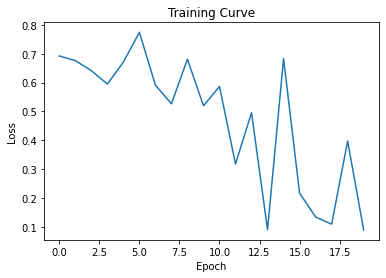

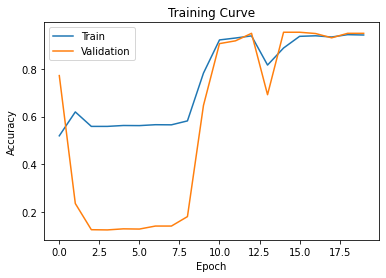

In [ ]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

val_iter = torchtext.data.BucketIterator(valid,
                                         batch_size=32,
                                         sort_key=lambda x: len(x.sms), # to minimize padding
                                         sort_within_batch=True,        # sort within each batch
                                         repeat=False)                  # repeat the iterator for many epochs

model = smsRNN(input_size=len(text_field.vocab.itos), hidden_size=50, num_classes=2)

train_rnn_network(model, train_iter, val_iter, num_epochs=20, learning_rate=1e-4)

1. **train_rnn_network(model, train_iter, val_iter, num_epochs=10, learning_rate=1e-4), bs=32, hs=50** -  Accuracy was very chaotic with no clear trend, more epochs definitely required

2. **train_rnn_network(model, train_iter, val_iter, num_epochs=20, learning_rate=1e-4), bs=32, hs=50** - Produced the best results, the loss decreased significantly over each epoch and the training and validation accuracies also converged closer to 20 epochs.

3. **train_rnn_network(model, train_iter, val_iter, num_epochs=20, learning_rate=1e-5), bs=64, hs=100** - Some oscillations with the accuracy, was very up and down with no clear pattern

4. **train_rnn_network(model, train_iter, val_iter, num_epochs=20, learning_rate=1e-5), bs=64, hs=50** - No real improvement, large batch size could be the issue, smaller batch size yielded better results.



### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = None # TODO

### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

A **false positive** would mean that a real message would be marked as spam. The impact of this is that you would miss this message when it may be useful if sent directly to spam.

A **false negative** would mean that a spam message would be marked as real. The impact of this is that you're inbox may receive undesired spam messages when you think that the spam detection is preventing this. Although this would be a nuisance, the impact wouldn't be as severe as a false positive, since you would potentially be missing an important message in that case.


## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
test_iter = torchtext.data.BucketIterator(test,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

test_accuracy = get_accuracy(model, test_iter)
print("TEST ACCURACY = ", round(test_accuracy * 100, 2), "%")

TEST ACCURACY =  94.23 %


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# DATASET of ALL SPAM
test_spam = torchtext.data.Dataset( [e for e in test.examples if e.label == 1], 
                                   test.fields)

test_spam_iter = torchtext.data.BucketIterator(test_spam,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

spam_acc = get_accuracy(model, test_spam_iter)
print("FALSE NEGATIVE RATE: ", round((1 - spam_acc) * 100, 2), "%")


# DATASET of NON SPAM
test_nospam = torchtext.data.Dataset([e for e in test.examples if e.label == 0],
                                     test.fields) 

test_nospam_iter = torchtext.data.BucketIterator(test_nospam,
                                           batch_size=64,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

nospam_acc = get_accuracy(model, test_nospam_iter)
print("FALSE POSITIVE RATE: ", round((1 - nospam_acc) * 100, 2), "%")

FALSE NEGATIVE RATE:  11.39 %
FALSE POSITIVE RATE:  5.03 %


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"

characters = []
for i in msg:
  characters += [text_field.vocab.stoi[char]]

characters = torch.tensor(characters)
characters = characters.reshape(1, len(characters))

out = model(characters)
soft_out = torch.softmax(out, dim = 1)
pred = torch.argmax(soft_out, axis = 1)

if pred == 0:
  print("this msg is not spam")
elif pred == 1:
  print("this msg is spam")

this msg is spam


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

I think detecting spam would be a difficult task as vocabulary evolves rapidly and people have done a good job of masking messages to appear not as spam. It becomes increasingly difficult to detect these messages as a result.

A simple baseline model that may be applied is a logistic regression. A logistic regression can serve as a binary classifier since it maps values to either 0 or 1. In this context, it could definitely apply since we only need to differentiate between spam and not spam. Essentially, we would just need to normalize the data between 0 and 1 and then run the regressor. Given an input message, if the resulting output is 1, we consider this as spam, and if the output is 0, we consider it not spam.